In [2]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


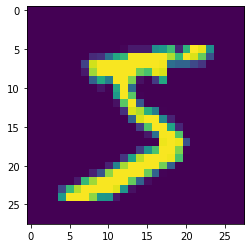

In [4]:
plt.imshow(x_train[0])

In [5]:
#reshape to 1D vector with size 784, instead of 2D vector of size 28x28
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

#normalize data into range 0-1
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [6]:
#size of noise vector
noise_dim = 100
#optimizer
adam = Adam(lr = 0.0002, beta_1 = 0.5)

In [7]:
### Discriminator

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [8]:
### Generator

generator = Sequential()
generator.add(Dense(256, input_dim = noise_dim, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(784, activation='sigmoid'))  # 28x28 Values between 0 and 1
generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [9]:
#do not want to train yet
discriminator.trainable = False

#input tensor is the 100dim Noise vector
inputs = Input(shape = (noise_dim,))

#output of GAN is the result of discriminator from generator output. 
generate = generator(inputs)
classify = discriminator(generate) #output

#combining generator and discriminator model
gan = Model(inputs, classify)
gan.compile(loss = 'binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [10]:
#function to plot the losses for both the discriminator and the generator
def plot_losses(losses):

  discriminator_loss = [v[0] for v in losses["D"]]
  generator_loss = [v[0] for v in losses["G"]]

  plt.figure(figsize=(8,6))
  plt.plot(discriminator_loss, label = "Discriminator Loss")
  plt.plot(generator_loss, label = "Generator Loss")

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

#defining fuction that will display the images generated by the generator
def plot_generated_imgs(num_imgs = 10, dim = (1,10), figsize = (12,2)):
  noise = np.random.normal(0,1,size = (num_imgs, noise_dim))

  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(num_imgs,28,28)

  plt.figure(figsize = figsize)
  for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
  plt.tight_layout()
  plt.show()


In [13]:
### Training
losses = {"D":[], "G":[]} #to store loss data


def train(epochs=1, plot_freq=1, BATCH_SIZE=128):

    batches = int(x_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batches)

    for e in range(epochs):
      if e == 1 or e%plot_freq == 0: #checking if output is wanted based on plot_freq
          print('='*15, 'Epoch %d' %e, '='*15) #print formatting
      for _ in range(batches):
          # Create a batch of real images from training set
          img = x_train[np.random.randint(0, x_train.shape[0], size=BATCH_SIZE)]

          # Create noise vectors for the generator
          noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
          # Generate batch of fake images
          generated_images = generator.predict(noise)
          #combine real and fake images for training
          images = np.concatenate((img, generated_images))
          # Create labels
          labels = np.zeros(2*BATCH_SIZE)
          labels[:BATCH_SIZE] = 0.9  # One-sided label smoothing

          # Train discriminator on generated images
          discriminator.trainable = True
          discriminator_loss = discriminator.train_on_batch(images, labels)

          # Training generator, losses are based on the GAN
          noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
          labels2 = np.ones(BATCH_SIZE) #all images are said to be real
          discriminator.trainable = False
          generator_loss = gan.train_on_batch(noise, labels2)

      #store losses from final batch of epoch
      losses["D"].append(discriminator_loss)
      losses["G"].append(generator_loss)

      if e == 1 or e%plot_freq == 0:
        plot_generated_imgs()
    plot_losses(losses)


Epochs: 200
Batch size: 128
Batches per epoch: 468
=============== Epoch 0 ===============


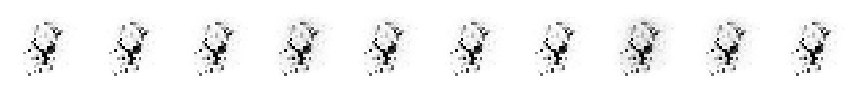

=============== Epoch 1 ===============


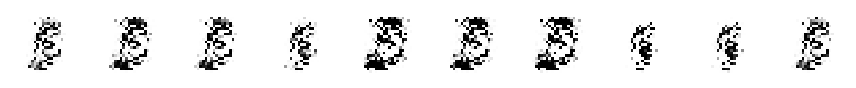

=============== Epoch 20 ===============


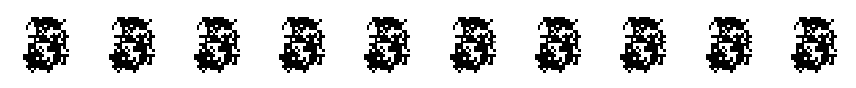

=============== Epoch 40 ===============


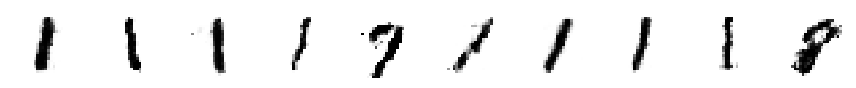

=============== Epoch 60 ===============


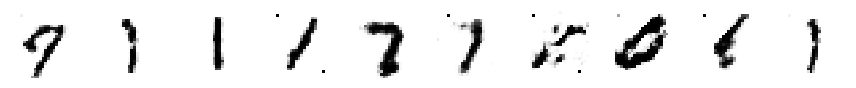

KeyboardInterrupt: ignored

In [14]:
train(epochs = 200, plot_freq = 20, BATCH_SIZE = 128) #about 60mins runtime